## Imports

In [1]:
# File
import pathlib

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from timeseries import preproc, evaluate

Using TensorFlow backend.


In [3]:
# Charting
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
# Deep Learning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, Dropout, MaxPooling2D, Reshape, Flatten, BatchNormalization
from keras.optimizers import Adam

## Get Data

In [5]:
# Available files
pathlib.os.listdir('data')

['acc.csv', 'vel.csv', 'exc.csv', 'disp.csv']

In [6]:
print('Reading acc')
acc_raw = np.genfromtxt('./data/acc.csv', delimiter=',')
print('Reading vel')
vel_raw = np.genfromtxt('./data/vel.csv', delimiter=',')
print('Reading exc')
exc_raw = np.genfromtxt('./data/exc.csv', delimiter=',')
print('Reading disp')
disp_raw = np.genfromtxt('./data/disp.csv', delimiter=',')

Reading acc
Reading vel
Reading exc
Reading disp


In [7]:
acc_df = pd.DataFrame(acc_raw.T, columns=['acc','acc_10noise'])
vel_df = pd.DataFrame(vel_raw.T, columns=['vel','vel_10noise'])
exc_df = pd.DataFrame(exc_raw.T, columns=['exc','exc_10noise'])
disp_df = pd.DataFrame(disp_raw.T, columns=['disp','disp_10noise'])

In [8]:
data = pd.concat([acc_df, vel_df, exc_df, disp_df], axis=1)

In [9]:
def plot_stacked_timesseries(data, top_col, bottom_col, quantity, top_y_label, bottom_y_label):
    sns.set(style="ticks", color_codes=True)
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data.loc[:, top_col], '.-')
    plt.title(quantity + ' over Time')
    plt.ylabel(top_y_label)

    plt.subplot(2, 1, 2)
    plt.plot(data.index, data.loc[:, bottom_col], '.-')
    plt.xlabel('time (units)')
    plt.ylabel(bottom_y_label)
    plt.show()

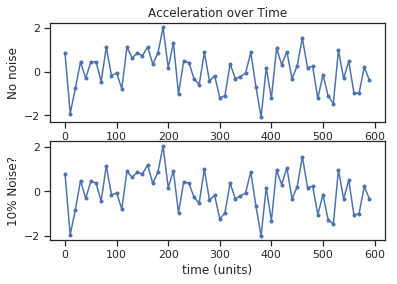

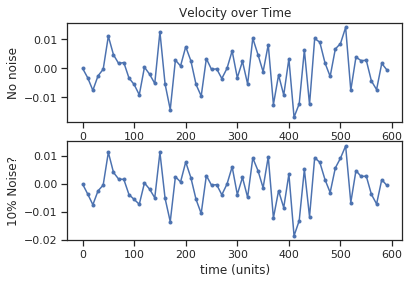

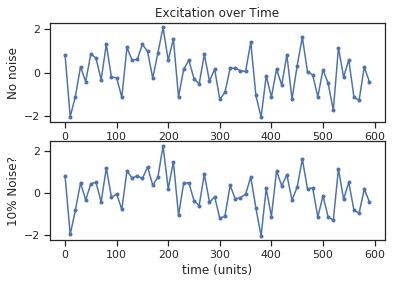

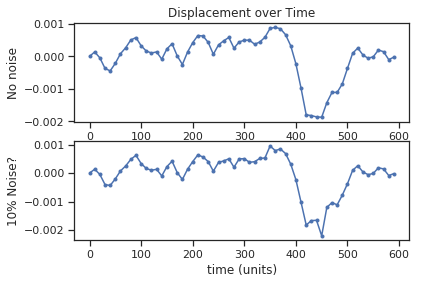

In [10]:
for info in [(acc_df, 'acc', 'acc_10noise', 'Acceleration'), 
             (vel_df, 'vel', 'vel_10noise', 'Velocity'),
             (exc_df, 'exc', 'exc_10noise', 'Excitation'),
             (disp_df, 'disp', 'disp_10noise', 'Displacement')]:
    
    plot_stacked_timesseries(info[0].iloc[:600:10], info[1], info[2],
                             info[3], 'No noise','10% Noise?')

## Preprocessing

In [11]:
no_noise_data = data.loc[:, [x for x in data.columns if 'noise' not in x]]
noise_data = data.loc[:, [x for x in data.columns if 'noise' in x]]

In [12]:
input_scaled = pd.DataFrame()
for col in no_noise_data.columns:
    mean = no_noise_data[col].mean()
    minimum = no_noise_data[col].min()
    maximum = no_noise_data[col].max()
    input_scaled[col] = (no_noise_data[col]-mean)/(maximum - minimum)
    input_scaled[col] = input_scaled[col] / 2.0 + 0.5
    
noise_input_scaled = pd.DataFrame()
for col in noise_data.columns:
    mean = noise_data[col].mean()
    minimum = noise_data[col].min()
    maximum = noise_data[col].max()
    noise_input_scaled[col] = (noise_data[col]-mean)/(maximum - minimum)
    noise_input_scaled[col] = noise_input_scaled[col] / 2.0 + 0.5

In [13]:
input_data_scaled = input_scaled.drop('disp',axis=1)
output_data_scaled = input_scaled['disp']

noise_input_data_scaled = noise_input_scaled.drop('disp_10noise',axis=1)
noise_output_data_scaled = noise_input_scaled['disp_10noise']

In [14]:
input_data_scaled.head()

,acc,vel,exc
0,0.540818,0.500000,0.540522
1,0.474899,0.505608,0.476769
2,0.547336,0.513542,0.551074
3,0.541087,0.545093,0.554383
4,0.456274,0.544150,0.470235


In [15]:
input_trim = input_data_scaled[:int(len(input_data_scaled)*0.1)].values
output_trim = output_data_scaled[:int(len(output_data_scaled)*0.1)].values

In [145]:
n_input = 100
n_output = 100
td_l = input_trim.shape[0]

In [146]:
data_frac_index = int(td_l*0.1)
x_holdout = input_data_scaled[data_frac_index:data_frac_index+1000].values.reshape(-1,n_input,3)
y_holdout = output_data_scaled[data_frac_index:data_frac_index+1000].values.reshape(-1,1)

In [147]:
x_indices = [range(i, i+n_input) for i in range(td_l-n_input)]
y_indices = [range(i, i+n_output) for i in range(td_l-n_output)]

In [148]:
x = input_trim[x_indices]
y = output_trim[y_indices]

## Cleanup

In [20]:
del acc_df,vel_df,exc_df,disp_df,no_noise_data,noise_data,acc_raw,vel_raw,disp_raw,exc_raw

## Model

In [356]:
def build_model(n_timesteps, n_features, n_outputs):
    
    # Optimiser
    opt = Adam(lr=0.001)
    
    # define model
    model = Sequential()
    model.add(Conv2D(9, (2,1), input_shape=(n_timesteps, n_features, 1)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(9, (2,1), input_shape=(n_timesteps, n_features, 1)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dense(n_outputs))
    
    model.add(Reshape((100,1)))
    model.add(LSTM(200))
    
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    
    return model

In [357]:
# Get model
mdl = build_model(100, 3, 100)

In [358]:
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 99, 3, 9)          27        
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 49, 3, 9)          0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 49, 3, 9)          0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 49, 3, 9)          36        
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 48, 3, 9)          171       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 24, 3, 9)          0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 24, 3, 9)          0         
__________

In [359]:
history = mdl.fit(x.reshape(-1, n_input, 3, 1), y,
                 epochs=10,
                 batch_size=1000)

Epoch 1/10
165900/165900 [==============================] - 21s 127us/step - loss: 0.0125 - mean_absolute_error: 0.0629
Epoch 2/10
165900/165900 [==============================] - 17s 101us/step - loss: 0.0015 - mean_absolute_error: 0.0305
Epoch 3/10
165900/165900 [==============================] - 17s 101us/step - loss: 7.3083e-04 - mean_absolute_error: 0.0212
Epoch 4/10
165900/165900 [==============================] - 17s 101us/step - loss: 5.0280e-04 - mean_absolute_error: 0.0177
Epoch 5/10
165900/165900 [==============================] - 17s 101us/step - loss: 4.0571e-04 - mean_absolute_error: 0.01590s - loss: 4.0708e-04 - mean_absolute_error: 
Epoch 6/10
165900/165900 [==============================] - 17s 101us/step - loss: 3.3888e-04 - mean_absolute_error: 0.0145
Epoch 7/10
165900/165900 [==============================] - 17s 101us/step - loss: 3.1384e-04 - mean_absolute_error: 0.0140
Epoch 8/10
165900/165900 [==============================] - 17s 101us/step - loss: 2.9692e-04 -

In [360]:
y_hats = mdl.predict(x_holdout.reshape(-1, n_input, 3, 1))
y_hats = y_hats.reshape(-1, 1)

In [361]:
resids = (y_hats - y_holdout.reshape(-1,1))

In [362]:
ys_df = pd.concat([pd.Series(y_hats.reshape(-1), name='preds'), pd.Series(y_holdout.reshape(-1), name='true')], axis=1)
resids_df = pd.DataFrame(resids, columns=['disp_resids'])

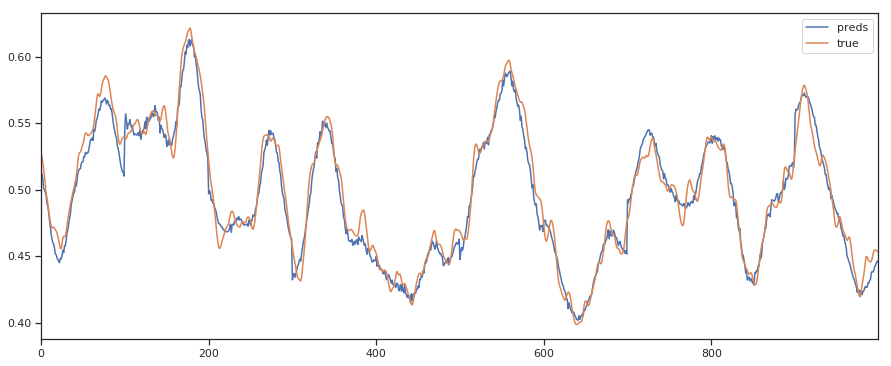

In [363]:
ys_df.plot(figsize=(15,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ca14a65f8>]],
      dtype=object)

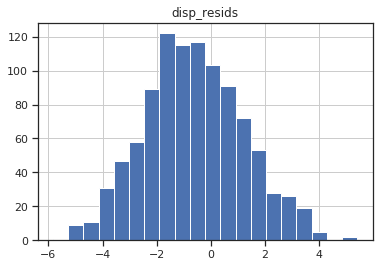

In [364]:
(resids_df * 100 / 0.5).hist(bins=20)

In [365]:
resids_df.std()/0.5 * 100

disp_resids    1.845919
dtype: float64

In [366]:
resids_df.mean()

disp_resids   -0.003116
dtype: float64